## Imports

In [185]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import visualkeras

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

## Load Data

In [186]:
data_dir = 'data'

def load_images_from_dir(directory, label):
    data = []
    labels = []
    
    image_files = os.listdir(directory)
    
    # Load each image and append it to the data list along with its label
    for img_file in image_files:
        img_path = os.path.join(directory, img_file)
        image = cv2.imread(img_path, 1)
        image = np.array(image)
        data.append(image)
        labels.append(label)
    
    return data, labels

# Load galaxy images
galaxy_path = os.path.join(data_dir, 'images', 'galaxy')
galaxy_data, galaxy_labels = load_images_from_dir(galaxy_path, label=0)

# Load star images
star_path = os.path.join(data_dir, 'images', 'star')
star_data, star_labels = load_images_from_dir(star_path, label=1)

# Combine data and labels from both classes
data = galaxy_data + star_data
labels = galaxy_labels + star_labels

# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Combine data and labels from both classes into a dataframe
galaxy_df = pd.DataFrame({'data': galaxy_data, 'label': galaxy_labels})
star_df = pd.DataFrame({'data': star_data, 'label': star_labels})
df = pd.concat([galaxy_df, star_df], ignore_index=True)


## Exploring Data

In [187]:
# Print the shapes of data and labels
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

print('------------------------')

# Print the first few rows of the combined dataframe
print("Combined DataFrame:")
df.head()

Data shape: (3986, 64, 64, 3)
Labels shape: (3986,)
------------------------
Combined DataFrame:


,data,label
0,"[[[66, 66, 66], [105, 105, 105], [128, 128, 12...",0
1,"[[[172, 172, 172], [140, 140, 140], [137, 137,...",0
2,"[[[114, 114, 114], [90, 90, 90], [159, 159, 15...",0
3,"[[[68, 68, 68], [19, 19, 19], [104, 104, 104],...",0
4,"[[[43, 43, 43], [97, 97, 97], [30, 30, 30], [6...",0


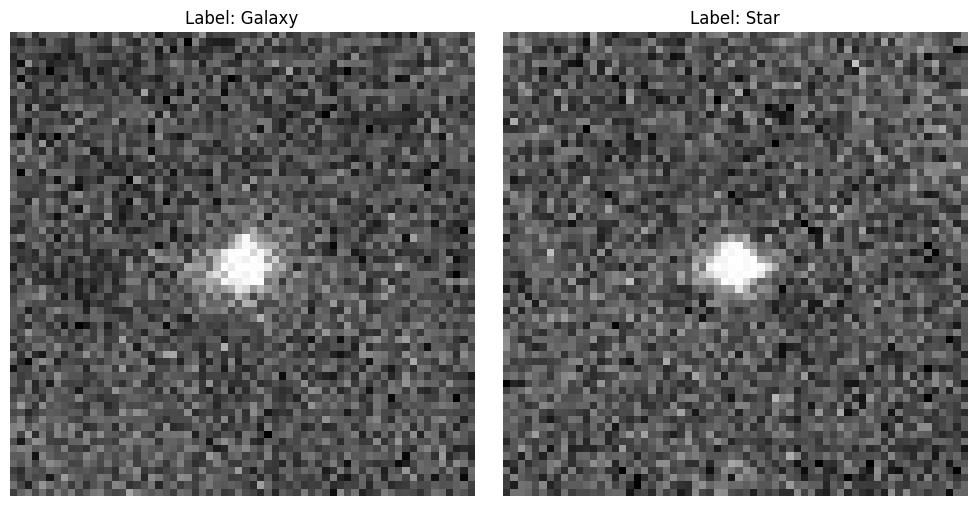

In [188]:
# Select one image for each label
galaxy_image = df[df['label'] == 0].iloc[0]['data']
star_image = df[df['label'] == 1].iloc[0]['data']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot galaxy image
axes[0].imshow(galaxy_image)
axes[0].set_title('Label: Galaxy')
axes[0].axis('off')

# Plot star image
axes[1].imshow(star_image)
axes[1].set_title('Label: Star')
axes[1].axis('off')

plt.tight_layout()
plt.show()

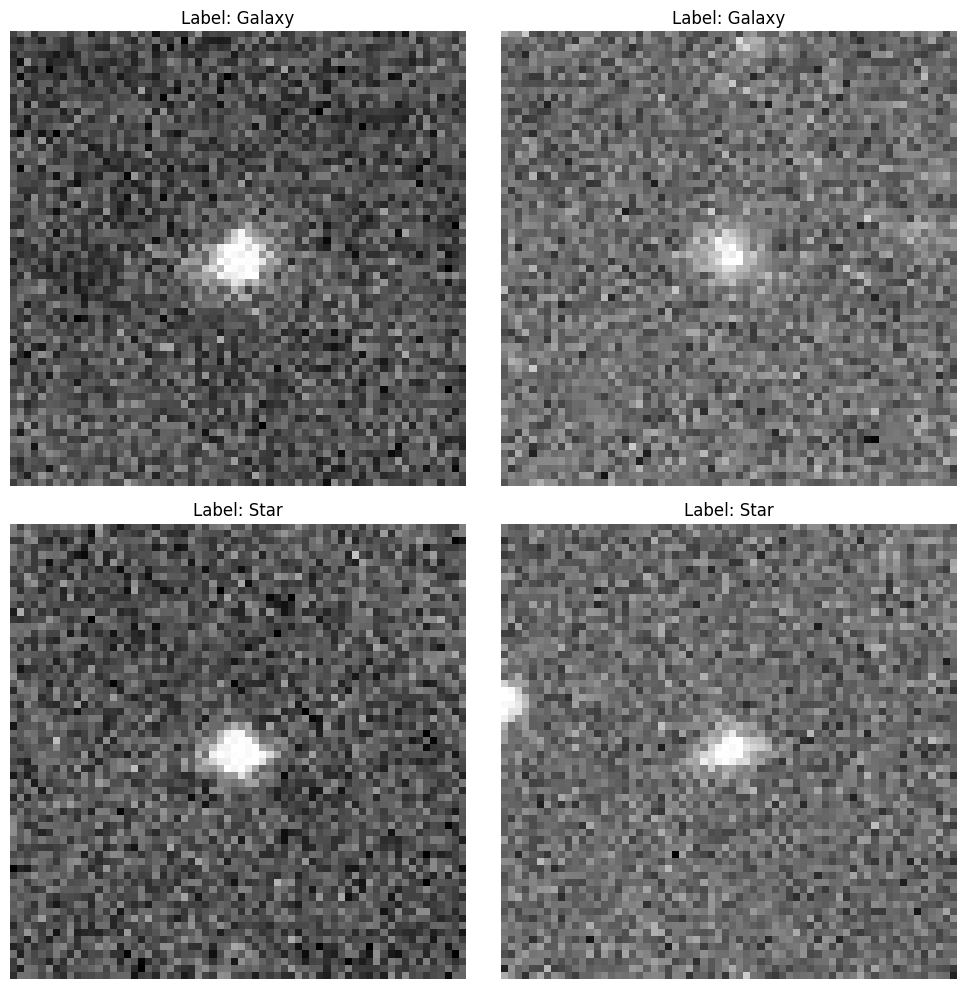

In [189]:
# Select images for each label
galaxy_images = df[df['label'] == 0]['data'].iloc[:2]
star_images = df[df['label'] == 1]['data'].iloc[:2]


fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot galaxy images
for i, image in enumerate(galaxy_images):
    axes[0, i].imshow(image)
    axes[0, i].set_title('Label: Galaxy')
    axes[0, i].axis('off')

# Plot star images
for i, image in enumerate(star_images):
    axes[1, i].imshow(image)
    axes[1, i].set_title('Label: Star')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


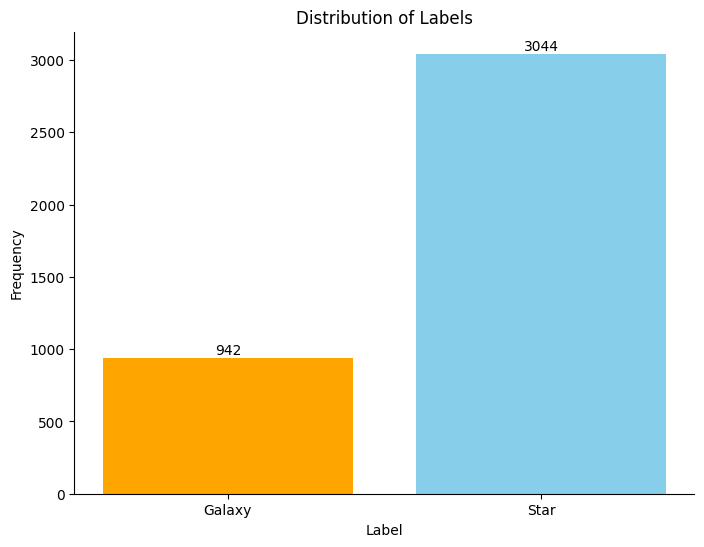

In [190]:
# Count the occurrences of each label
label_counts = df['label'].value_counts()


plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=['skyblue', 'orange'])

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Add counts on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f'{int(bar.get_height())}', ha='center', va='bottom')

plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Distribution of Labels')
plt.xticks(label_counts.index, ['Star', 'Galaxy'])

plt.show()

## Image Preprocessing
### Convert to Grayscale

In [191]:
grayscale_data = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in data]
grayscale_data = np.array(grayscale_data)

# reshape to include 1 channel
grayscale_data = grayscale_data.reshape(-1, 64, 64, 1)

print("Grayscale Data Shape:", grayscale_data.shape)

Grayscale Data Shape: (3986, 64, 64, 1)


### Split Data

In [192]:
X_train, X_test, y_train, y_test = train_test_split(grayscale_data, labels, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

### Distribution of classes

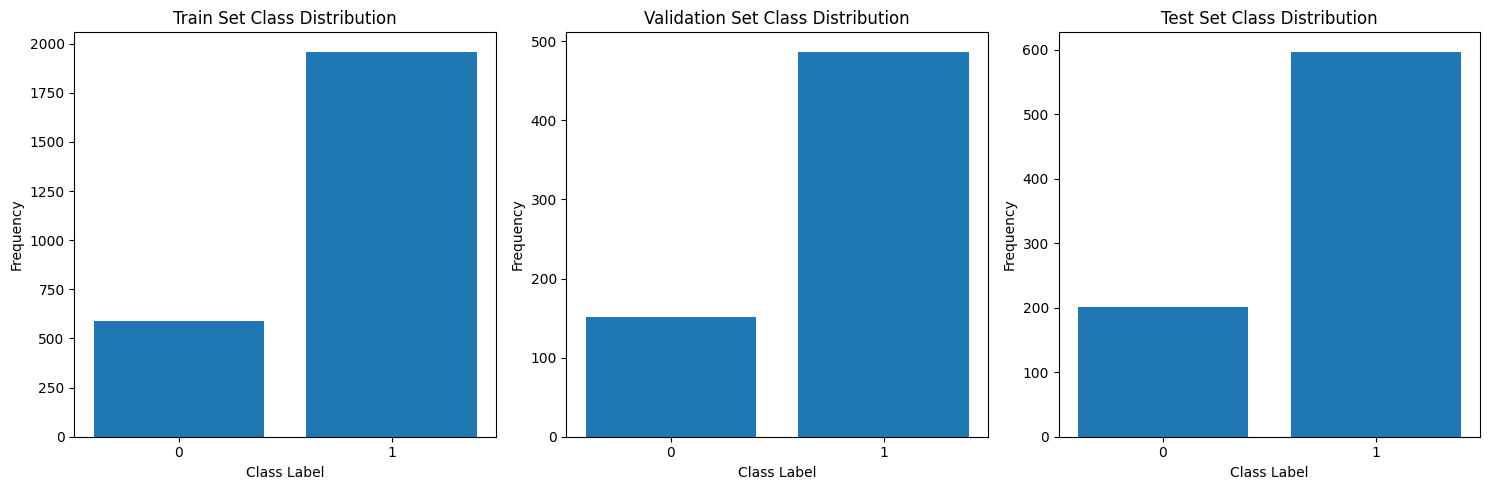

In [193]:
# Count the occurrences of each class label in train, validation, and test sets
train_unique, train_counts = np.unique(y_train, return_counts=True)
val_unique, val_counts = np.unique(y_val, return_counts=True)
test_unique, test_counts = np.unique(y_test, return_counts=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(train_unique, train_counts)
axes[0].set_title('Train Set Class Distribution')
axes[0].set_xlabel('Class Label')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(train_unique) 

axes[1].bar(val_unique, val_counts)
axes[1].set_title('Validation Set Class Distribution')
axes[1].set_xlabel('Class Label')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(val_unique) 

axes[2].bar(test_unique, test_counts)
axes[2].set_title('Test Set Class Distribution')
axes[2].set_xlabel('Class Label')
axes[2].set_ylabel('Frequency')
axes[2].set_xticks(test_unique)

plt.tight_layout()
plt.show()


### Encode Target Variable

In [101]:
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

### Normalization

In [102]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

### Modeling

In [103]:
model = Sequential()
model.add(InputLayer(shape=(64, 64, 1)))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters = 64, kernel_size= (4,4), padding = 'same', activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(rate = 0.2))

model.add(Conv2D(filters = 128, kernel_size= (4,4), padding = 'same', activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters = 128, kernel_size= (4,4), padding = 'same', activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(rate = 0.2))

model.add(Conv2D(filters = 256, kernel_size= (4,4), padding = 'same', activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters = 256, kernel_size= (4,4), padding = 'same', activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(rate = 0.2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate = 0.2))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer = Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [104]:
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ max_pooling2d_64 (MaxPooling2D) │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 32, 32, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_114 (Conv2D)             │ (None, 4, 4, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 2, 2, 256)      │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 1, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,985,538 (7.57 MB)

 Trainable params: 1,985,026 (7.57 MB)

 Non-trainable params: 512 (2.00 KB)

### Train Model

In [106]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [107]:
history = model.fit(X_train, y_train, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stop], epochs=100)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.6881 - loss: 0.6482 - val_accuracy: 0.7633 - val_loss: 0.5737
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.7655 - loss: 0.4721 - val_accuracy: 0.7633 - val_loss: 0.5157
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.8110 - loss: 0.3944 - val_accuracy: 0.7633 - val_loss: 0.5322
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8305 - loss: 0.3717 - val_accuracy: 0.7633 - val_loss: 0.5218
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8274 - loss: 0.3755 - val_accuracy: 0.7633 - val_loss: 0.4885
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.8566 - loss: 0.3264 - val_accuracy: 0.7633 - val_loss: 0.4903
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.8419 - loss: 0.3486 - val_accuracy: 0.7633 - val_loss: 0.4558
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8700 - loss: 0.3118 - val_accuracy: 0.

### Verify Model Performance

In [108]:
metrics = pd.DataFrame(model.history.history)

In [51]:
metrics.head()

,accuracy,loss,val_accuracy,val_loss
0,0.614510,1.612041,0.998433,0.686094
1,0.651765,0.582951,0.283699,0.698455
2,0.734902,0.516191,0.194357,0.739272
3,0.805490,0.418127,1.000000,0.337365
4,0.847843,0.347252,0.000000,0.853857


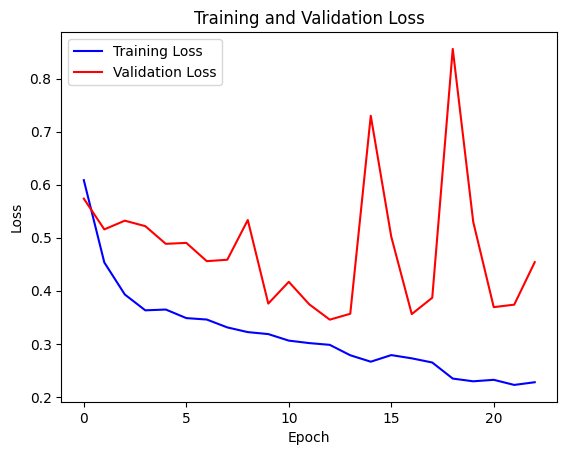

In [109]:
plt.plot(metrics['loss'], label='Training Loss', color='blue')
plt.plot(metrics['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

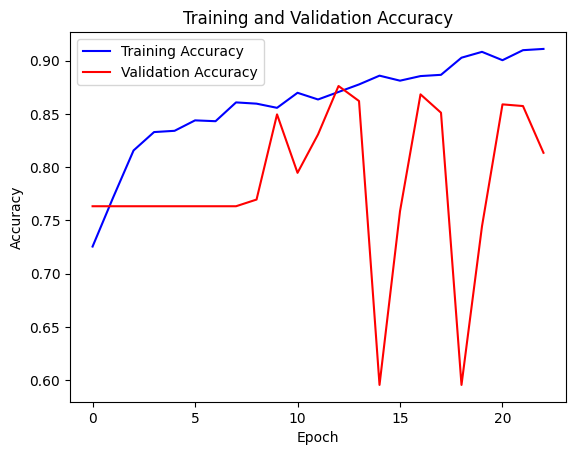

In [110]:
plt.plot(metrics['accuracy'], label='Training Accuracy', color='blue')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [111]:
model.evaluate(X_test, y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8112 - loss: 0.3955


[0.40535712242126465, 0.8007518649101257]

### Visualize Model Performance

In [124]:
predictions = model.predict(X_test)
prediction_classes = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [174]:
# Generate classification report
report = classification_report(y_true, prediction_classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.569536,0.855721,0.683897,201.000000
1,0.941532,0.782245,0.854529,597.000000
accuracy,0.800752,0.800752,0.800752,0.800752
macro avg,0.755534,0.818983,0.769213,798.000000
weighted avg,0.847834,0.800752,0.811550,798.000000


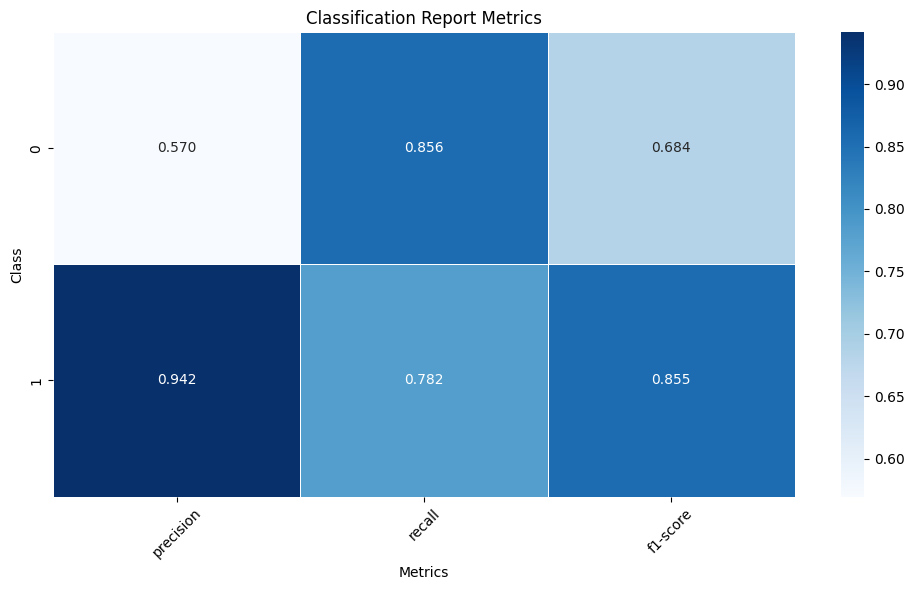

In [172]:
report_df_filtered = report_df.drop(columns='support')

plt.figure(figsize=(10, 6))
sns.heatmap(report_df_filtered.drop(['accuracy', 'macro avg', 'weighted avg']), annot=True, cmap='Blues', fmt='.3f', linewidths=.5)
plt.title('Classification Report Metrics')
plt.xlabel('Metrics')
plt.ylabel('Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

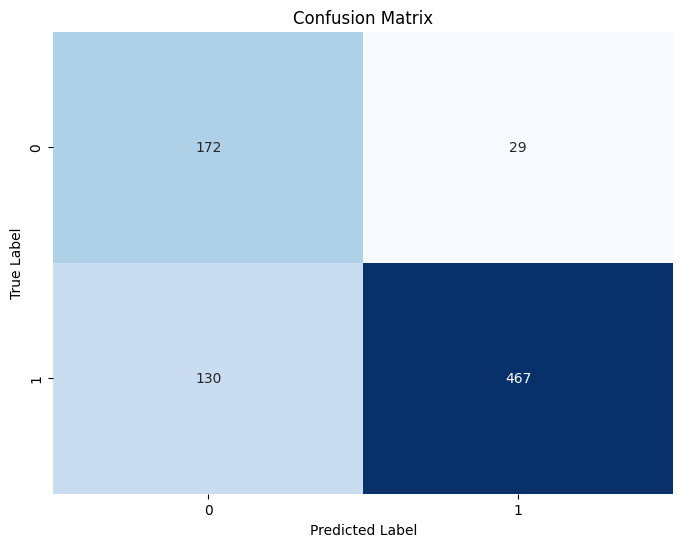

In [175]:
conf_matrix = confusion_matrix(y_true, prediction_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()